In [1]:
# 1. Import Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import plotly.express as px

In [2]:
# 2. Load and Prepare the Data
data = pd.read_csv("C:/Users/Aleena Mary Abraham/OneDrive/Desktop/SCMA632_2025/DATA/Apple Stock Price History.csv")
data.columns = data.columns.str.replace(".", "_", regex=False)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Price', 'Vol_']].rename(columns={'Vol_': 'Volume'})

In [3]:
# 3. Handle Missing Values
data['Price'] = data['Price'].interpolate()

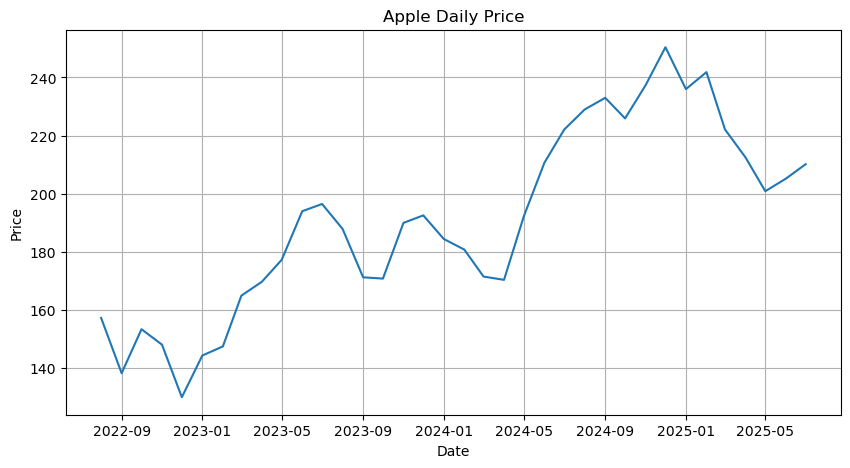

In [4]:
# 4. Plot Daily Price Data
plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['Price'])
plt.title('Apple Daily Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [5]:
# 5. Split into Train and Test
data = data.sort_values('Date')
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

In [ ]:
# 6. Monthly Aggregation
def convert_volume(x):
    if isinstance(x, str):
        x = x.replace(',', '').strip()
        if x.endswith('B'):
            return float(x[:-1]) * 1e9
        elif x.endswith('M'):
            return float(x[:-1]) * 1e6
        elif x.endswith('K'):
            return float(x[:-1]) * 1e3
        else:
            try:
                return float(x)
            except:
                return np.nan
    return x

data['Volume'] = data['Volume'].apply(convert_volume)
monthly_data = data.resample('M', on='Date').mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_data['Date'], monthly_data['Price'])
plt.title('Apple Monthly Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [ ]:
# 7. Time Series Decomposition
monthly_ts = monthly_data.set_index('Date')['Price']
monthly_ts = monthly_ts.asfreq('M')
monthly_ts = monthly_ts.dropna()
decomp_add = seasonal_decompose(monthly_ts, model='additive', period=12)
decomp_add.plot()
plt.show()
decomp_mult = seasonal_decompose(monthly_ts, model='multiplicative', period=12)
decomp_mult.plot()
plt.show()

In [ ]:
# 8. Holt-Winters Forecasting
hw_model = ExponentialSmoothing(monthly_ts, seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(12)

plt.figure(figsize=(10,5))
plt.plot(monthly_ts, label='Observed', color='blue')
plt.plot(hw_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 9. ARIMA Forecasting on Daily Data
daily_data = data.set_index('Date').asfreq('D')
daily_data['Price'] = daily_data['Price'].interpolate()
daily_ts = daily_data['Price']

arima_model = auto_arima(daily_ts, seasonal=False, stepwise=True)
model_fit = ARIMA(daily_ts, order=arima_model.order).fit()
forecast_arima = model_fit.forecast(steps=63)

plt.figure(figsize=(10,5))
plt.plot(daily_ts, label='Observed')
plt.plot(pd.date_range(daily_ts.index[-1], periods=64, freq='D')[1:], forecast_arima, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 10. Decision Tree & Random Forest
train_data['Date_num'] = train_data['Date'].astype(np.int64) // 10**9
test_data['Date_num'] = test_data['Date'].astype(np.int64) // 10**9

# Decision Tree
model_dt = DecisionTreeRegressor().fit(train_data[['Date_num']], train_data['Price'])
test_data['Pred_DT'] = model_dt.predict(test_data[['Date_num']])

# Random Forest
model_rf = RandomForestRegressor().fit(train_data[['Date_num']], train_data['Price'])
test_data['Pred_RF'] = model_rf.predict(test_data[['Date_num']])

In [ ]:
# Plotting
plt.figure(figsize=(10,5))
plt.plot(test_data['Date'], test_data['Price'], label='Actual', color='blue')
plt.plot(test_data['Date'], test_data['Pred_DT'], label='Decision Tree', color='red')
plt.plot(test_data['Date'], test_data['Pred_RF'], label='Random Forest', color='green')
plt.title('Decision Tree & Random Forest Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()